Upload CONTENT image (your photo):


Saving content.jpg to content.jpg

Upload STYLE image (artwork):


Saving style.jpg to style.jpg


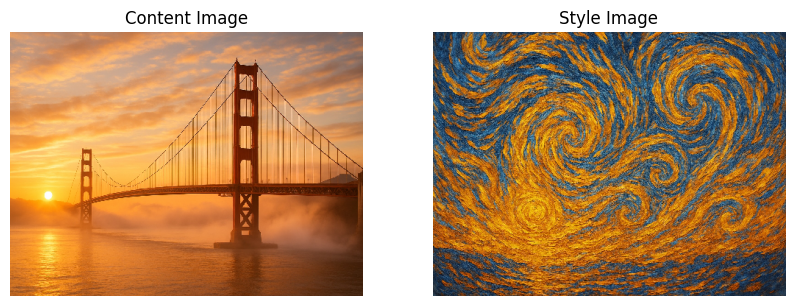

In [2]:


import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# ========== 1. FIRST UPLOAD IMAGES ==========
from google.colab import files

def upload_images():
    print("Upload CONTENT image (your photo):")
    content_path = list(files.upload().keys())[0]

    print("\nUpload STYLE image (artwork):")
    style_path = list(files.upload().keys())[0]

    return content_path, style_path

content_path, style_path = upload_images()

# ========== 2. THEN LOAD AND DISPLAY ==========
def load_and_display(content_path, style_path, height=360, width=480):
    # Load images
    content_img = img_to_array(load_img(content_path, target_size=(height, width)))[..., :3]
    style_img = img_to_array(load_img(style_path, target_size=(height, width)))[..., :3]

    # Display
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(content_img/255.0)  # Normalize to [0,1]
    plt.title("Content Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(style_img/255.0)
    plt.title("Style Image")
    plt.axis('off')
    plt.show()

    return content_img, style_img

# Now properly load and display
content_img, style_img = load_and_display(content_path, style_path)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 79.9MB/s]


Step 500, Total loss: 21984.439453125
Step 1000, Total loss: 14685.017578125
Step 1500, Total loss: 12252.783203125
Step 2000, Total loss: 10998.2734375


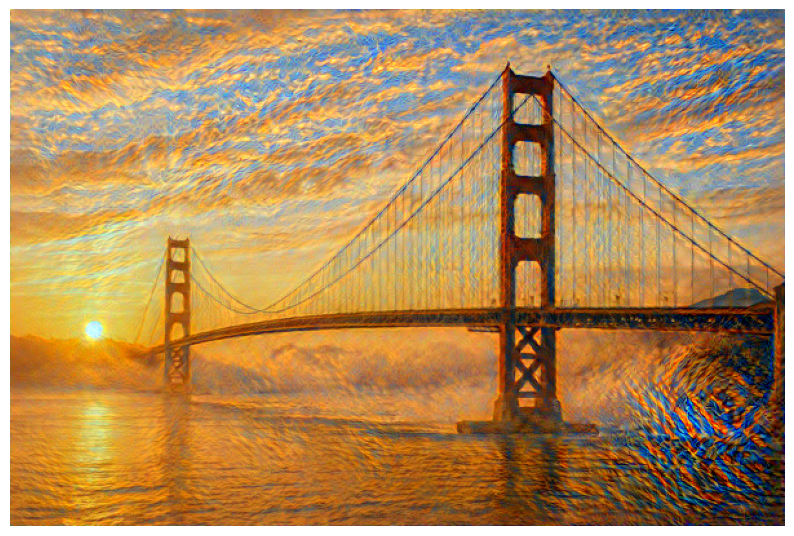

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import copy

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image loader
def load_image(image_path, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))  # ImageNet standards
    ])

    # Add batch dimension
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    return image.to(device)

# Function to unnormalize and show images
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * [0.229, 0.224, 0.225]
    image = image + [0.485, 0.456, 0.406]
    image = image.clip(0, 1)
    return image

# Load content and style images
content = load_image('content.jpg')
style = load_image('style.jpg', shape=content.shape[-2:])
# Load pretrained VGG19
vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features.to(device).eval()

# Freeze model parameters
for param in vgg.parameters():
    param.requires_grad_(False)

# Define layers to use
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  # content representation
                  '28': 'conv5_1'}

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

# Gram Matrix
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# Get features
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Calculate Gram matrices for style image
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create a target image
target = content.clone().requires_grad_(True).to(device)

# Style weights
style_weights = {'conv1_1': 1.0,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1e4  # alpha
style_weight = 1e2    # beta

# Define optimizer
optimizer = optim.Adam([target], lr=0.003)

# Style Transfer Loop
steps = 2000  # number of iterations

for ii in range(1, steps+1):

    # Get features from target
    target_features = get_features(target, vgg)

    # Content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # Style loss
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss

    # Update target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Print loss
    if ii % 500 == 0:
        print('Step {}, Total loss: {}'.format(ii, total_loss.item()))

# Final image
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.imshow(im_convert(target))
plt.axis('off')
plt.show()
